# Inverse graphics using graphics-based generative models and MCMC

### Installation:
Don't run this code (I'm not even sure if you can; there may be permission issues), 
but I am including it to show how we installed Mitsuba3 in our environment
which is by using a Conda environment

```julia
using Pkg
Pkg.activate("myenv")
Pkg.add("Conda")
using Conda
Conda.pip("install", "mitsuba")

```

In [2]:
using Pkg
Pkg.activate("myenv")
using Distributions
using ProgressMeter
using Gen, Plots
using Parameters
using PyCall
numpy = pyimport("numpy")
mi = pyimport("mitsuba")
mi.set_variant("scalar_rgb")
@pyinclude("./cbox-generic.py")

  Activating project at `~/Algorithms-of-the-Mind/labs/lab-05/myenv`


# Brief Mitsuba3 Introduction

Mitsuba3 is a physically-based graphics rendered. This means that instead of taking some of the common shortcuts (rasterization), it more faithfully captures the physical process by which light bounces of surfaces and creates images. This process is called ray-tracing, in which rays are simulated from the light sources in the scene, which bouncess off of the surfaces and gets sensed by a sensor (e.g., eye, camera) placed somewhere in the scene.

For our purposes Mitsuba3 serves as 

In [2]:
#use the teapot and transform it in various ways
scene_d = py"initialize_scene()"o
# load a scene with a teapot
scene = mi.load_dict(scene_d)

# read a data structure of what is in this scene 
params = @pycall mi.traverse(scene)::PyObject

modelparams = ModelParams(scene = scene)
mitsuba_render_2(modelparams)

# Review this output and the xml file itself, which 

LoadError: UndefVarError: `ModelParams` not defined

# Inverse graphics

We start by writing our generative model -- which in this case wraps a graphics engine 

In [3]:
@with_kw struct ModelParams
    path::String = "./cbox_generic.xml"
    scene::PyObject = @pycall mi.load_file(path)::PyObject
    spp::Int32 = 16
end

function mitsuba_transform(scene_d, object, scale, translation)
    t = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
    lb = PyObject(get(scene_d, object))
    set!(lb, "to_world", t)
    set!(scene_d, object, lb)
    return scene_d
end

function mitsuba_render(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
    mu = @pycall numpy.array(bitmap)::Array{Float64, 3}
    mu[:, :, 1]
end

function mitsuba_render_2(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
end

mitsuba_render_2 (generic function with 1 method)

In [4]:
@gen function room()

    scene_d = py"initialize_scene()"o::PyObject
    
    # prior over the scale of the left sphere
    s_left ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_left = [-0.3, -0.5, 0.2]
    scene_d = mitsuba_transform(scene_d, "left-object", s_left, t_left)
    
    # prior over the scale of the right sphere
    s_right ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_right = [0.5, -0.75, -0.2] 
    scene_d = mitsuba_transform(scene_d, "right-object", s_right, t_right)

    scene = mi.load_dict(scene_d)
    modelparams = ModelParams(scene=scene)

    mu = mitsuba_render(modelparams)

    pred ~ broadcasted_normal(mu, 2.0)

end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##room#292", Bool[], false)

In [5]:
function view_image(t)
    scene_d = py"initialize_scene()"o::PyObject
    t_left = [-0.3, -0.5, 0.2]
    mitsuba_transform(scene_d, "left-object", t[:s_left], t_left)
    
    t_right = [0.5, -0.75, -0.2] 
    mitsuba_transform(scene_d, "right-object", t[:s_right], t_right)
    scene = mi.load_dict(scene_d)
    scene_to_render = ModelParams(scene=scene)
    bitmap = mitsuba_render_2(scene_to_render)
end

view_image (generic function with 1 method)

In [6]:
trace = Gen.simulate(room, ())
get_choices(trace)

│
├── :s_left : 0.9818425376339103
│
├── :pred : [-2.336770804154713 0.26981528176054875 0.7296498158601523 2.5946196887983555 -1.0566233089171673 0.07029134653900687 -0.0523690135096471 1.0769065396366195 4.064379639094209 1.417391344629563 -0.4300823320566312 -3.8231975355602335 -0.3118314779008611 -0.674994680448865 2.6891564364015084 -1.422129290149506 -4.194086605739346 2.9450043690405145 3.435535160799627 0.7551093324723925 0.5490079897119038 -0.5234899351673027 0.9743756953892485 0.34032615227798835 1.1272280473829583 -1.307278659686874 2.571189734512135 0.9580621159833261 -0.3421278919564644 -1.1569234673388673 -0.2916142626862344 0.10164838770631619 -0.030783392621293464 0.1806038035625589 -0.4904506460604943 2.920455187974579 -0.4834122598006576 1.3871658661585804 -1.9902467990298927 -2.641655835620543 -0.5730274526149604 0.5828541956961966 -3.0675465668054 5.520130796000802 1.5727685232164068 -0.3900839936095166 1.5766389291449168 0.9436349692354892 -1.5421536974717929 1.855

In [7]:
view_image(trace)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

### Now let's make an observed image using an entry in the Mitsuba gallery

In [8]:
obs_scene = ModelParams(path = "./scenes/cbox.xml", spp=64)
obs_bitmap = mitsuba_render_2(obs_scene)
obs_image = Gen.choicemap()
p = @pycall numpy.array(obs_bitmap)::Array{Float64, 3}
obs_image[:pred] = p[:, :, 1]
# to view the image on your notebook
obs_bitmap

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

### Inference: Random walk MH

In [9]:
# include the truncated norm distribution
include("truncatednorm.jl")

In [10]:
# proposal distribution for the scale variables
@gen function scale_proposal(current_trace)
    # trunc_norm(mean, std, lower_bound, upper_bound)
    # why do we need a truncated norm, instead of a regular normal distribution?
    s_left ~ trunc_norm(current_trace[:s_left], 0.2, 0.1, 1.)
    s_right ~ trunc_norm(current_trace[:s_right], 0.2, 0.1, 1.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##scale_proposal#293", Bool[0], false)

In [11]:
function random_walk_mh(tr)
    
    # make a random-walk update on scale variables
    (tr, accepted) = mh(tr, scale_proposal, ())

    # return the updated trace
    tr
end

random_walk_mh (generic function with 1 method)

In [16]:
function do_inference()
    K = 100
    t, = generate(room, (), obs_image)
    scores = Vector{Float64}(undef, K)
    @showprogress for i in 1:K
        t = random_walk_mh(t)
        scores[i] = get_score(t)
    end;
    return scores, t
end

do_inference (generic function with 1 method)

In [20]:
(scores, t) = do_inference()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


([-6612.381110871008, -6612.381110871008, -6612.789465929474, -6612.185195573324, -6612.185195573324, -6612.185195573324, -6612.185195573324, -6609.2428076023725, -6610.017952959203, -6610.017952959203  …  -6608.780932286082, -6608.780932286082, -6608.780932286082, -6608.780932286082, -6608.780932286082, -6608.780932286082, -6609.602546172295, -6609.602546172295, -6609.602546172295, -6609.158660176857], Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##room#292", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:s_left => Gen.ChoiceOrCallRecord{Float64}(0.5209740029959203, 0.10536051565782628, NaN, true), :pred => Gen.ChoiceOrCallRecord{Matrix{Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0004689645138569176 … 0.008372928015887737 0.0; … ; 0.0 0.0032056064810603857 … 0.004581848159432411 0.0; 0.0 0.0 … 0.0 0.0], -6609.369381208173, NaN, true), :s_right

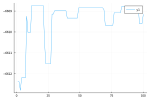

In [21]:
plot(scores)

In [22]:
view_image(t)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]